## Preface

If you never used a Jupuyter notebook before, you need to execute the different code blocks as you read along, in the order they arrive.

You execute a code block by selecting it and either press the run button above or by pressing shift+enter.

Try executing the import statements first!

In [5]:
import pandas as pd
import altair as alt
from sklearn import datasets
import numpy as np

# An introduction to K-means clustering

In this notebook, you will be introduced to one of the simplest existing clustering algorithms, namely __K-means__. 

The goal of K-means clustering is to partition a dataset of __n__ observations into __k__ clusters, in which each observation belongs to the cluster with the nearest mean.

The basic algorithm proceeds by alternating between 2 steps:
1. __Assign__ observations to the nearest cluster
2. __Update__ the cluster centers (means)

The algorithm alternates between these two steps until changes to the cluster centers (also known as centroids) are no longer observed.

However, before iterating over the 2 steps, you first need to compute a set of initial centroids, which can be done in a number of different ways. One way is simply to generate random centroids.

In the following, we will implement a basic version of K-means step-by-step and observe how we can cluster a random 2D dataset.

## Data!

First, let's create a random dataset with two dimensions (or features) named __x__ and __y__.

In [11]:
blobs = datasets.make_blobs(n_samples = 200, centers=3)
df = pd.DataFrame(blobs[0], columns=['x','y'])
df.head()

,x,y
0,4.992708,3.791876
1,-2.814758,6.847707
2,-0.319240,8.420426
3,3.544806,4.600660
4,3.167779,5.836951


For illustrative purposes, we are using the function _make_blobs_ to create a random dataset with __200 data points__ and __3 clusters__ (which we want to find with our K-means algorithm).

You can visualize the data in a scatterplot like this.

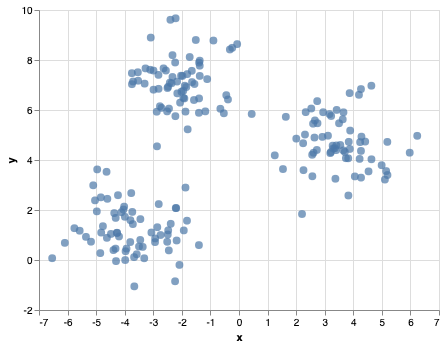

In [12]:
alt.Chart(df).mark_circle(size=60).encode(
    x='x',
    y='y'
).interactive()

## Distances!

Now let's get started on our algorithm. 

In order to compute the nearest center, we need to define what we mean by nearest. I.e., we need to create a distance function. 

In K-means, the distance measurement is the Euclidean distance, which is the "straight-line" distance between two points. 

Thus, in the case of 2D points, such as $(x_1, y_1)$ and $(x_2, y_2)$, the euclidean distance formula becomes $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$.

The function below returns the euclidean distance between a point and a centroid. The function also works for points in higher dimensional spaces.

In [19]:
def euclidean_distance(point, centroid):
    return np.sqrt(np.sum((point - centroid)**2))

## Random centroids!

We also need a function that can compute a set of random centroids, which we need to initialize our algorithm.

This function returns __k__ random centroids within the bounds of our data, where __k__ is the number of clusters we aim to compute.

In [14]:
def random_centroids(k):   
    df_min = df[['x', 'y']].min()
    df_max = df[['x', 'y']].max()
    return pd.DataFrame([np.random.random_sample((2,)) * (df_max - df_min) + df_min for i in range(k)], columns=['x', 'y'])

## Init!

Now we are ready to initialize things.

For this we need to specify a __k__ and compute our random centroids.

To make things explicit, we are also generating a set of labels for our centroids.

In [38]:
k = 5
centroids = random_centroids(k)
centroid_labels = []
for i in range(k):
    label = 'c_%d' % i
    centroid_labels.append(label)
centroid_labels

['c_0', 'c_1', 'c_2', 'c_3', 'c_4']

Now we can also visualize not only our dataset but also the current centroids.

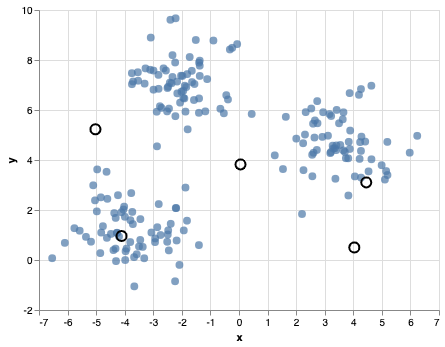

In [39]:
data_marks = alt.Chart(df).mark_circle(size=60).encode(
        x='x',
        y='y',
    ).interactive()

centroid_marks = alt.Chart(centroids).mark_point(size=100, opacity=1, color='black').encode(
        x='x',
        y='y',
    ).interactive()

data_marks + centroid_marks

## Assign!

Next, we need to assign observations to their nearest centroid. 

For this, we first need to create a function that calculates the distances between all points and centroids using the Euclidean distance function defined above. 

Calling this function, will populate three new columns in our dataframe with the respective distances.

In [20]:
def calc_distances():
    for i in range(k):
        df[centroid_labels[i]] = df[['x', 'y']].apply(euclidean_distance, centroid=centroids.iloc[i], axis=1)  

In [40]:
calc_distances()
df.head()

,x,y,c_0,c_1,c_2,cluster,c_3,c_4
0,4.992708,3.791876,10.121128,4.940576,3.424995,c_1,9.532618,0.873341
1,-2.814758,6.847707,2.742749,4.166600,9.338042,c_1,6.027532,8.175494
2,-0.319240,8.420426,5.688973,4.611097,9.036633,c_1,8.367347,7.143962
3,3.544806,4.600660,8.593921,3.577812,4.127100,c_1,8.475927,1.750308
4,3.167779,5.836951,8.216926,3.709083,5.404288,c_1,8.760100,3.019622


We can now define a function that will assign the observations to the centroid with the shortest distance.

This function will also populate a new column with the assigned cluster.

In [22]:
def assign():
    df['cluster'] = df[centroid_labels].idxmin(axis=1)

In [41]:
assign()
df.head()

,x,y,c_0,c_1,c_2,cluster,c_3,c_4
0,4.992708,3.791876,10.121128,4.940576,3.424995,c_4,9.532618,0.873341
1,-2.814758,6.847707,2.742749,4.166600,9.338042,c_0,6.027532,8.175494
2,-0.319240,8.420426,5.688973,4.611097,9.036633,c_1,8.367347,7.143962
3,3.544806,4.600660,8.593921,3.577812,4.127100,c_4,8.475927,1.750308
4,3.167779,5.836951,8.216926,3.709083,5.404288,c_4,8.760100,3.019622


By updating our code for the scatter plot, we can color data points based on their current cluster assignment.

In [24]:
def plot_result():
    data_marks = alt.Chart(df).mark_circle(size=60, opacity=0.5).encode(
        x='x',
        y='y',
        tooltip=['x', 'y', 'cluster'],
        color=alt.Color('cluster', scale=alt.Scale(scheme='category10'))
    ).interactive()

    centroid_marks = alt.Chart(centroids).mark_point(size=100, opacity=1, color='black').encode(
        x='x',
        y='y',
    ).interactive()

    return data_marks + centroid_marks

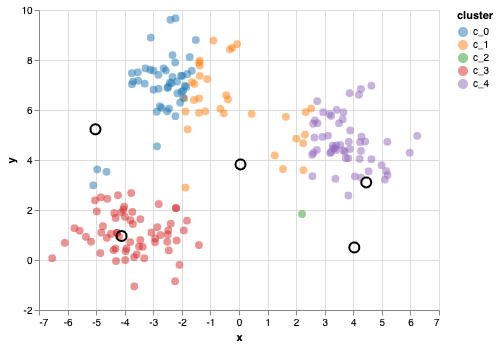

In [42]:
plot_result()

## Update!

As you have probably observed by now, the centroids are not located in the middle of the assigned data points.

Thus, to update the centroids, we are simply calculating the mean of the assigned data points along each feature.

In [26]:
def update_centroids():
    for i in range(k):
        centroids.iloc[i] = df[df['cluster']==centroid_labels[i]][['x', 'y']].mean()

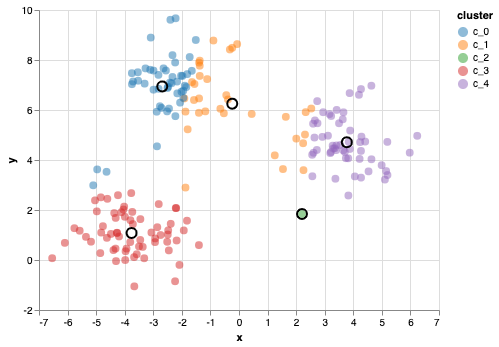

In [46]:
update_centroids()
plot_result()

## Iterate until convergence!

Finally, all that is left is to iterate until the clusters no longer change. 

We simply define a function that does the assigment and centroid updates in one go. 

In [28]:
def iterate():
    calc_distances()
    assign()
    update_centroids()

Try executing the code block below until you think the result is stable.

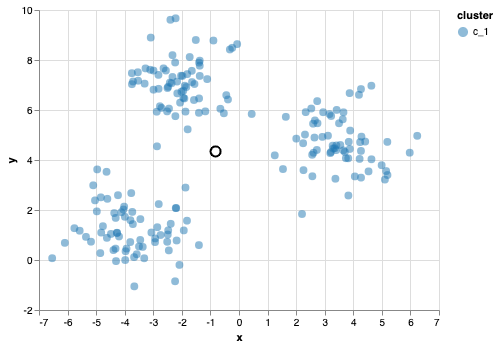

In [37]:
iterate()
plot_result()

Congratulations, you are now able to K-means clustering.

Tip: You can play around with different datasets and k to see how the algorithm behaves.

## Epilogue

There are several challenges with K-means in practice. Just to name a few: you need to provide k, the method does not guarantee a global optimum, and the algorithm relies on proper initialization.

Still, due to it's simplicity and speed, the algorithm is still very useful in multiple scenarios.

For more information on drawbacks and merrits of different clustering approaches, see https://scikit-learn.org/stable/modules/clustering.html.

Scikit-learn also have handy more methods for generating different types of random data, and most importantly, proper implementations of not only multiple clustering algorithms but ML algorithms in general.